In [1]:
from datetime import datetime as dt
from datetime import timedelta
import logging
import importlib
import urllib
import unicodecsv as csv
from lxml import html
import requests
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
import json
import sys
from requests.auth import HTTPProxyAuth
import time
import os
%matplotlib inline

In [2]:
#Script is written right now for before cleaned, single region. Must adapt for cleaned and multi-region.
#This will include changing "price" to "rent"
#QUESTION: Unclear what is actually being counted in 'score' variable

#cleandf = pd.read_csv('C:\\Users\\james\\Documents\\Berkeley_Docs\\Spring_17_Courses\\CP290 Data Lab\\github\\scraper2\\shared_room_scraper\\sfbay_merged_2017_04_10.csv', header=0) #just SF dataframe
df = pd.read_csv('C:\\Users\\james\\Documents\\Berkeley_Docs\\Spring_17_Courses\\CP290 Data Lab\\github\\scraper2\\shared_room_scraper\\all_data_merged_2017_04_six_nine.csv',error_bad_lines=False, header=0) #all listings dataframe
#determine rent per square foot


In [3]:
df.shape

(83241, 21)

In [4]:
df.loc[df.lat == 99, 'lat'] = 0
df.loc[df.lng == 99, 'lng'] = 0
df.loc[df.sqft == 0, 'sqft'] = np.nan

In [ ]:
df.tail()

In [5]:
#For any duplicate post, we want to keep the version with the most information. Therefore, assign a score to each post and 
#give one point for square footage, lat, long and price
#OLD FORMULA
#cleandf['score']=cleandf.astype(bool).sum(axis=1)

df['price_exists'] = df['price']>0
df['sqft_exists'] = df['sqft']>0
df['lat_exists'] = df['lat']>0
df['lng_exists'] = df['lng']<0
df['score'] = df[['price_exists','sqft_exists','lat_exists','lng_exists']].astype(bool).sum(axis=1)

In [6]:
#Sort rows by score
df = df.sort_values(by='score',ascending=False)

In [22]:
df.shape

(83241, 29)

In [23]:
dedupe1 = pd.DataFrame(df.drop_duplicates(subset='pid', inplace=False))

In [25]:
dedupe1 = pd.DataFrame(df.drop_duplicates(subset='body_text', inplace=False))

In [26]:
dedupe1.shape

(53814, 29)

In [27]:
dedupe1.to_csv('dedupedtest.csv')

In [10]:
#List as 'true' if the PID, body_text, or the title are duplicates
df['body_text_duplicate']=df.duplicated('body_text')
df['title_duplicate']=df.duplicated('title')
df['PID_duplicate']=df.duplicated('pid')


In [9]:
df[df['title_duplicate']==True].to_csv('titleduplicates.csv')

In [11]:
df_dedupe1 = df.drop_duplicates('pid')
df_dedupe1.shape

(67591, 29)

In [12]:
#Keep rows with highest score. Drop rows with duplicate PIDs, Duplicate Titles, Duplicate Posting Bodies
df_dedupe2 = df_dedupe1.drop_duplicates('body_text')
df_dedupe2.shape

(53052, 29)

In [13]:
df_unique = df_dedupe2.drop_duplicates('title')
df_unique.shape

(44275, 29)

### Quick bar chart to see impact of deduplication on sample size

In [14]:
y = [len(df),len(df_dedupe1), len(df_dedupe2), len(df_unique)]

In [15]:
labels = ['original', 'dedupe-pid', 'dedupe-body', 'dedupe-title']
x = [1,2,3,4]

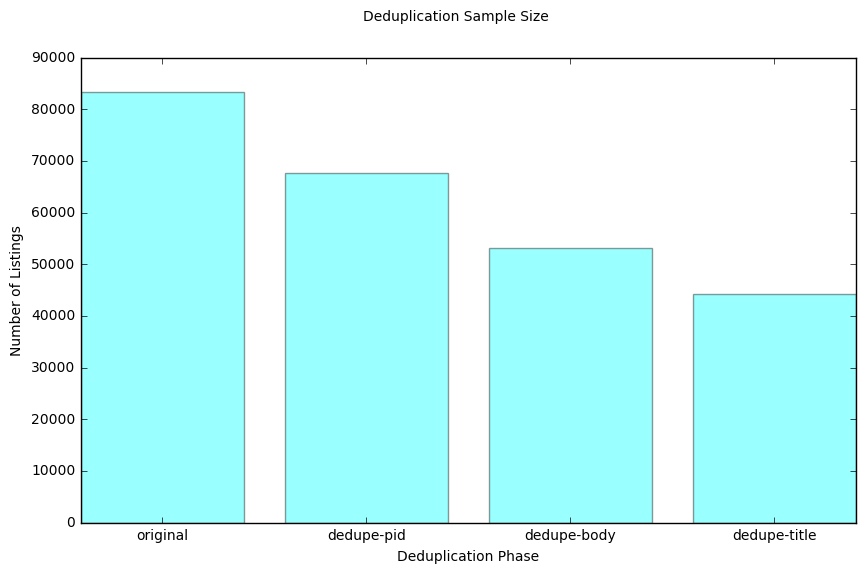

In [16]:
plt.figure(figsize=(10,6) )
plt.suptitle('Deduplication Sample Size')
plt.xlabel('Deduplication Phase')
plt.ylabel('Number of Listings')
plt.xticks(x, labels)
ax = plt.bar(x, y, alpha=.4, color='cyan', align='center')
plt.show()

## Creating new fields for analysis

In [17]:
df_unique['dt'] = pd.to_datetime(df_unique['dt'], format='%Y-%m-%d')
df_unique['region'] = df_unique['url'].str.extract('http://(.*).craigslist.org', expand=False)
df_unique['day_of_week'] = df_unique['dt'].apply(lambda x: x.weekday())
df_unique['rent_sqft'] = df_unique['price'] / df_unique['sqft']

C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [18]:
df_unique['date'] = pd.DatetimeIndex(df_unique.dt).normalize()

C:\Users\james\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
#counting listings per day (right now inlcudes time, need to remove)
listings_per_date = df_unique['date'].value_counts()

In [20]:
listings_per_date

2017-04-07    11823
2017-04-06    11241
2017-04-08    10924
2017-04-09     9565
2017-04-05      722
Name: date, dtype: int64

## Descriptive Stats and More Filtering

In [21]:
df_unique.describe()

,pid,price,sqft,lat,lng,accuracy,score,day_of_week,rent_sqft
count,4.427500e+04,3.763900e+04,11561.000000,44275.000000,44275.000000,44275.000000,44275.000000,44275.000000,11293.000000
mean,6.070954e+09,4.131364e+04,1094.934089,29.001617,-73.571868,33.782473,2.650887,4.392298,24.342165
std,1.159473e+07,4.110828e+06,5655.453129,16.420992,43.926016,36.247011,1.120115,1.129657,1394.739340
min,6.033041e+09,1.000000e+00,1.000000,0.000000,-157.826600,0.000000,0.000000,2.000000,0.000133
25%,6.066096e+09,4.800000e+02,180.000000,26.566461,-117.026850,10.000000,2.000000,3.000000,0.439189
50%,6.076564e+09,6.500000e+02,880.000000,36.184072,-80.060345,22.000000,3.000000,4.000000,1.085740
75%,6.079055e+09,9.000000e+02,1400.000000,40.667215,-71.124125,22.000000,3.000000,5.000000,3.968254
max,6.081892e+09,6.007005e+08,567890.000000,64.976382,0.000000,99.000000,4.000000,6.000000,125137.645833


In [28]:
unique_wprice = df_unique[df_unique['price'] > 0]

In [29]:
# in this cell, define the values by which we will filter the 3 columns. This will vary depending on the sample we're looking at. 
upper_percentile = 0.9965
lower_percentile = 0.03

# how many rows would be within the upper and lower percentiles?
upper = int(len(unique_wprice) * upper_percentile)
lower = int(len(unique_wprice) * lower_percentile)

# get the rent/sqft values at the upper and lower percentiles
rent_sqft_sorted = unique_wprice['rent_sqft'].sort_values(ascending=True, inplace=False)
upper_rent_sqft = rent_sqft_sorted.iloc[upper]
lower_rent_sqft = rent_sqft_sorted.iloc[lower]

# get the rent values at the upper and lower percentiles
rent_sorted = unique_wprice['price'].sort_values(ascending=True, inplace=False)
upper_rent = rent_sorted.iloc[upper]
lower_rent = rent_sorted.iloc[lower]

# get the sqft values at the upper and lower percentiles
sqft_sorted = unique_wprice['sqft'].sort_values(ascending=True, inplace=False)
upper_sqft = sqft_sorted.iloc[upper]
lower_sqft = sqft_sorted.iloc[lower]

print('valid rent_sqft range:', [lower_rent_sqft, upper_rent_sqft])
print('valid rent range:', [lower_rent, upper_rent])
print('valid sqft range:', [lower_sqft, upper_sqft])

valid rent_sqft range: [0.2540415704387991, nan]
valid rent range: [135.0, 5500.0]
valid sqft range: [120.0, nan]


In [30]:
#Filtering out rows with unreasonable rent prices 
rent_mask = (unique_wprice['price'] > lower_rent) & (unique_wprice['price'] < upper_rent)

In [31]:
filtered_listings = pd.DataFrame(unique_wprice[rent_mask])

## Filtering out listings with "0" latitudes

In [32]:
lat_mask = (filtered_listings['lat'] > 0)

In [33]:
filtered_listings = pd.DataFrame(filtered_listings[lat_mask])

In [34]:
filtered_listings.describe()

,pid,price,sqft,lat,lng,accuracy,score,day_of_week,rent_sqft
count,2.858700e+04,28587.000000,9626.000000,28587.000000,28587.000000,28587.000000,28587.000000,28587.000000,9626.000000
mean,6.071399e+09,789.809949,1059.594536,37.819549,-95.732687,14.037010,3.336726,4.366600,4.078380
std,1.131964e+07,402.665411,6007.601376,4.774827,20.326849,7.271881,0.472599,1.126008,29.497602
min,6.033041e+09,137.000000,1.000000,2.202179,-149.957812,0.000000,3.000000,2.000000,0.000572
25%,6.067161e+09,515.000000,175.000000,34.075226,-118.261552,7.000000,3.000000,3.000000,0.480000
50%,6.076733e+09,700.000000,850.000000,38.758710,-87.821300,15.000000,3.000000,4.000000,1.175000
75%,6.079111e+09,950.000000,1400.000000,40.744300,-76.296600,22.000000,4.000000,5.000000,4.069749
max,6.081892e+09,5100.000000,567890.000000,64.644000,-2.202279,40.000000,4.000000,6.000000,1200.000000


## Getting FIPS (Need to add to Istanbul script, too slow here)

In [ ]:
# Creating columns for FIPS
filtered_listings['FIPS'] = None
filtered_listings['state'] = None
filtered_listings['county'] = None

In [ ]:
#each row to the API call

for i, row in filtered_listings.iterrows():
    url = 'http://data.fcc.gov/api/block/find?format=json&latitude={0}&longitude={1}'
    request = url.format(row['lat'], row['lng'])
    response = requests.get(request)
    data = response.json()
    filtered_listings.loc[i,['FIPS','state','county']] = [data['Block']['FIPS'], data['State']['code'], data['County']['name']]

In [ ]:
[data['Block']['FIPS'], data['State']['code'], data['County']['name']]

### Filtering by amenities

In [ ]:
df_rooms = filtered_listings[filtered_listings['room_known']==True]

In [ ]:
df_rooms[df_rooms['private_room']==True].describe()

In [ ]:
df_rooms[df_rooms['private_room']==False].describe()

## Viewing Results by Region

In [35]:
# Here we're pulling select regions to do neighborhood analysis, as well as intraregional comparisons to the conventional 
# listings and inter-regional comparisons. 

#Top 30 regions by unique postings
filtered_listings['region'].value_counts().head(30)

newyork         4082
sfbay           3426
losangeles      1815
washingtondc    1756
boston          1064
sandiego         988
orangecounty     660
miami            650
seattle          631
chicago          571
portland         507
denver           438
atlanta          397
phoenix          368
philadelphia     356
houston          348
inlandempire     318
sacramento       305
austin           291
baltimore        288
newjersey        285
orlando          271
lasvegas         249
tampa            244
dallas           235
minneapolis      205
raleigh          181
norfolk          170
boulder          169
santabarbara     159
Name: region, dtype: int64

In [36]:
nylistings = filtered_listings[filtered_listings['region']=='newyork']

In [37]:
grouped = nylistings.groupby(by='neighb')

In [38]:
counted = grouped.count()

In [39]:
counted.reset_index(inplace=True)

In [40]:
goodNeighbs = counted['neighb'][counted['pid'] > 20].values

In [41]:
top_nyneighbs = nylistings[nylistings['neighb'].isin(goodNeighbs)]

In [42]:
top_nyneighbs.groupby('neighb')['price'].median()

neighb
Astoria                  925.0
BRONX                    475.0
Bedstuy                  900.0
Brooklyn                 940.0
Bushwick                 935.0
Chelsea                 1550.0
Crown Heights            900.0
East Harlem              982.0
East Village            1500.0
Elmhurst                 900.0
Financial District      1750.0
Flushing                 800.0
Gramercy                1400.0
Greenpoint              1050.0
Harlem / Morningside     975.0
Inwood / Wash Hts        900.0
Lower East Side         1325.0
Midtown East            1500.0
Midtown West            1450.0
Murray Hill             1600.0
Nolita / Bowery         1500.0
Park Slope              1192.5
Ridgewood                850.0
SoHo                    1450.0
Union Square            1400.0
Upper East Side         1350.0
Upper West Side         1375.0
West Village            1500.0
Williamsburg            1275.0
bushwick                 825.0
Name: price, dtype: float64

In [ ]:
sflistings = filtered_listings[filtered_listings['region']=='sfbay']
sfgrouped = sflistings.groupby(by='neighb')
sfcounted = sfgrouped.count()
sfcounted.reset_index(inplace=True)
sfgoodNeighbs = sfcounted['neighb'][sfcounted['pid'] > 20].values
top_sfneighbs = sflistings[sflistings['neighb'].isin(sfgoodNeighbs)]

In [ ]:
top_sfneighbs.groupby('neighb')['price'].median()

## Visualization

In [ ]:
x = filtered_listings['price']

In [ ]:
x = x.astype('int')

In [ ]:
plt.figure(1, figsize=(10,6) )
plt.suptitle('Rent Price Distribution')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
ax = plt.hist(x, bins=50, alpha=.4, color='r')
plt.show()

### Regional Comparisons

In [ ]:
# Here we're pulling select regions to do neighborhood analysis, as well as intraregional comparisons to the conventional 
# listings and inter-regional comparisons. 

In [ ]:
filtered_listings

## Counting Words in body text

In [43]:
np.sum(filtered_listings['body_text'].str.contains('professional'))

6160

In [ ]:
np.sum(filtered_listings['body_text'].str.contains('young'))

In [ ]:
np.sum(filtered_listings['body_text'].str.contains('20s'))

In [ ]:
np.sum(filtered_listings['body_text'].str.contains('30s'))

In [ ]:
#filtered_listings.to_csv('sfbay_filtered4_10.csv')

In [ ]:
# calculate the ratios of unique to duplicate listings for each region
listings_ratios = pd.DataFrame()

# number of total listings for each region
listings_ratios['cleandf'] = cleandf['region'].value_counts()

# number of duplicate listings for each region (ie, listings that share a pid with at least one other listing)
listings_ratios['duplicate_listings'] = duplicate_listings['region'].value_counts()

# number of unique listings for the region (ie, none share a pid with another listing)
listings_ratios['unique_listings'] = unique_listings['region'].value_counts()

# percent of this region's listings that are duplicates
listings_ratios['duplicate_ratio'] = listings_ratios['duplicate_listings'] / listings_ratios['all_listings']

# percent of this region's listings that are unique (ie, not duplicates)
listings_ratios['unique_ratio'] = listings_ratios['unique_listings'] / listings_ratios['all_listings']

listings_ratios.head()

### Comparing shared room listings to vacant listings

In [ ]:
# plot the ratios of unique and duplicate listings, by region
countdata = listings_ratios.sort_values(by='all_listings', ascending=False)[['unique_listings', 'duplicate_listings']].head(20)
countdata.columns = ['Unique Listings', 'Duplicate Listings']
ax = countdata.plot(kind='bar',
                    stacked=True,
                    figsize=[9, 6], 
                    width=0.6, 
                    alpha=0.5, 
                    color=['b','m'],
                    edgecolor='k',
                    grid=False)

ax.yaxis.grid(True)
ax.set_xticks(range(0, len(countdata)))
ax.set_xticklabels(countdata.index, rotation=40, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
ax.set_title('Unique and duplicate rental listings, by region', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Total number of listings', fontproperties=label_font)        

save_fig(plt.gcf(), 'count_unique_duplicate_listings.png')
plt.show()